In [1]:
# coding: utf-8
import os

import pandas as pd
import numpy as np
import scipy
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from mydatools.plot import plot_multiclass_feature_dist
from mydatools.features_generate import mean_encoding

% matplotlib inline

## Config

In [2]:
trn_path = './data/input/application_train.csv'
tst_path = './data/input/application_test.csv'
id_col = 'SK_ID_CURR'
label_col = 'TARGET'

submission_path = './data/output/submission/EDA.csv'
output_id_col = id_col
output_label_col = label_col

## Load Data

In [3]:
trn_df = pd.read_csv(trn_path)
trn_df['ds_type'] = 'trn'
trn_df[label_col] = trn_df[label_col].astype('int')

tst_df = pd.read_csv(tst_path)
tst_df['ds_type'] = 'tst'

full_df = pd.concat([trn_df, tst_df])

del(trn_df)
del(tst_df)

full_df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,ds_type
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341,trn
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040,trn
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN,trn
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,WEDNESDAY,NaN,NaN,NaN,NaN,NaN,NaN,trn
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,THURSDAY,NaN,NaN,NaN,NaN,NaN,NaN,trn


In [4]:
# dataset type
is_trn = full_df['ds_type'] == 'trn'
is_tst = full_df['ds_type'] == 'tst'

In [5]:
full_df.shape

(356255, 123)

**label非常不平衡，大约10: 1**

In [6]:
full_df[label_col].value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

## Features

In [7]:
feature_columns = []

def add_features(features):
    if not isinstance(features, list):
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])

### application_train/test

**numerical_features**

In [8]:
numerical_features = full_df.dtypes[full_df.dtypes != 'object'].index.tolist()
numerical_features = [c for c in numerical_features if c not in [id_col, label_col, 'ds_type']]
add_features(numerical_features)

In [9]:
full_df[numerical_features].describe()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
count,356219.000000,3.562550e+05,3.559770e+05,3.562550e+05,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,...,356255.000000,356255.000000,356255.000000,185200.000000,183392.000000,183392.000000,183392.000000,119949.000000,119949.000000,119949.000000
mean,27425.560657,5.877674e+05,5.280200e+05,1.701161e+05,0.006281,0.005808,0.231697,0.304399,0.029995,1.911564,...,0.229661,0.015649,0.051371,0.103193,0.977889,0.977903,0.977239,0.752283,0.755548,0.759452
std,14732.808190,3.986237e+05,3.660650e+05,2.235068e+05,0.104250,0.079736,0.855949,0.786915,0.191374,1.865338,...,0.420616,0.124113,0.220753,0.108041,0.057929,0.058562,0.063165,0.113267,0.112057,0.110112
min,1615.500000,4.500000e+04,4.050000e+04,2.565000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16731.000000,2.700000e+05,2.340000e+05,1.125000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.041500,0.976700,0.976700,0.976700,0.687200,0.691400,0.699400
50%,25078.500000,5.002110e+05,4.500000e+05,1.530000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.069000,0.981600,0.981600,0.981600,0.755200,0.758500,0.764800
75%,34960.500000,7.975575e+05,6.750000e+05,2.025000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.128700,0.986600,0.986600,0.986600,0.823200,0.825600,0.823600
max,258025.500000,4.050000e+06,4.050000e+06,1.170000e+08,9.000000,4.000000,27.000000,261.000000,8.000000,25.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**categorical_features**

In [10]:
categorical_features = full_df.dtypes[full_df.dtypes == 'object'].index.tolist()
full_df[categorical_features].nunique()

CODE_GENDER                    3
EMERGENCYSTATE_MODE            2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
ds_type                        2
dtype: int64

In [11]:
categorical_features = categorical_features[:-1] # 为了去掉ds_type
# 去掉分类数太多
# categorical_features = full_df[categorical_features].columns[full_df[categorical_features].nunique() <= 10]

# get dummies
temp_df = full_df[categorical_features].copy()
temp_df = pd.get_dummies(temp_df, prefix_sep=':')
for c in temp_df.columns:
    full_df[c] = temp_df[c]

# add features
add_features(temp_df.columns.tolist())

增加分类变量的mean-encoding，因为训练集和测试集完全随机分割，随意直接使用最普通的mean-encoding应该也不太会出现过拟合

In [12]:
for c in categorical_features:
    full_df, new_feat = mean_encoding(full_df, c, label_col, is_tst, return_feature_name=True)
    add_features(new_feat)

**恢复空值**

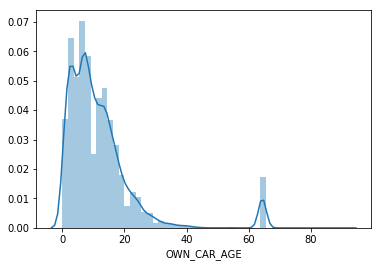

In [13]:
f = 'OWN_CAR_AGE'
sns.distplot(full_df[f][~full_df[f].isnull()])

In [14]:
full_df[f].value_counts().sort_index()

0.0     2252
1.0     5930
2.0     6832
3.0     7397
4.0     6909
5.0     4424
6.0     6880
7.0     8625
8.0     6984
9.0     5869
10.0    5570
11.0    4871
12.0    4849
13.0    5204
14.0    5300
15.0    4271
16.0    3804
17.0    3382
18.0    2788
19.0    2163
20.0    1764
21.0    1657
22.0    1467
23.0    1239
24.0    1278
25.0    1016
26.0     678
27.0     546
28.0     610
29.0     470
        ... 
33.0     150
34.0     203
35.0     179
36.0     138
37.0      91
38.0     107
39.0      86
40.0      98
41.0      64
42.0      52
43.0      20
44.0      24
45.0      11
46.0       5
47.0       1
48.0       1
49.0       7
50.0       2
51.0       3
52.0       2
54.0      12
55.0       5
56.0       2
57.0       1
63.0       2
64.0    2443
65.0    1350
69.0       1
74.0       1
91.0       2
Name: OWN_CAR_AGE, Length: 63, dtype: int64

In [15]:
# OWN_CAR_AGE 64,65
# full_df.loc[full_df['OWN_CAR_AGE'].isin([64,65]), 'OWN_CAR_AGE'] = np.nan

**各收入项占贷款比例**

In [16]:
full_df['AMT_INCOME_TOTAL_device_AMT_GOODS_PRICE'] = full_df['AMT_INCOME_TOTAL'] / full_df['AMT_GOODS_PRICE']
full_df['AMT_CREDIT_device_AMT_GOODS_PRICE'] = full_df['AMT_CREDIT'] / full_df['AMT_GOODS_PRICE']
full_df['AMT_ANNUITY_device_AMT_GOODS_PRICE'] = full_df['AMT_ANNUITY'] / full_df['AMT_GOODS_PRICE']
full_df['AMT_INCOME_TOTAL_device_AMT_ANNUITY'] = full_df['AMT_INCOME_TOTAL'] / full_df['AMT_ANNUITY']
full_df['AMT_CREDIT_device_AMT_ANNUITY'] = full_df['AMT_CREDIT'] / full_df['AMT_ANNUITY']

new_features = [
    'AMT_INCOME_TOTAL_device_AMT_GOODS_PRICE',
    'AMT_CREDIT_device_AMT_GOODS_PRICE',
    'AMT_ANNUITY_device_AMT_GOODS_PRICE',
    'AMT_INCOME_TOTAL_device_AMT_ANNUITY',
    'AMT_CREDIT_device_AMT_ANNUITY',
]
add_features(new_features)

In [17]:
full_df[new_features].describe()

,AMT_INCOME_TOTAL_device_AMT_GOODS_PRICE,AMT_CREDIT_device_AMT_GOODS_PRICE,AMT_ANNUITY_device_AMT_GOODS_PRICE,AMT_INCOME_TOTAL_device_AMT_ANNUITY,AMT_CREDIT_device_AMT_ANNUITY
count,355977.000000,355977.000000,355941.000000,356219.000000,356219.000000
mean,0.459271,1.124213,0.061961,7.335334,21.005276
std,0.581067,0.124172,0.025477,8.944140,7.783368
min,0.011801,0.150000,0.007500,0.493897,8.036674
25%,0.225000,1.000000,0.043245,4.363841,14.910747
50%,0.350000,1.118800,0.054095,6.128134,20.000000
75%,0.562500,1.198000,0.075920,8.699435,26.260412
max,257.425743,6.000000,0.300000,4466.586497,45.305079


**DAYS_XX**

DAYS_EMPLOYED看起来被填充过缺失值365243，把它恢复到na

In [18]:
full_df[full_df['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

array([365243])

In [19]:
full_df.loc[full_df['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = np.nan

然后增加DAYS_XX相关特征除以DAYS_BIRTH

In [20]:
full_df[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH
count,356255.000000,291607.000000,356255.000000,356255.000000
mean,-16041.248841,-2396.698937,-4983.593527,-3002.071163
std,4358.803980,2334.479967,3526.968986,1517.901735
min,-25229.000000,-17912.000000,-24672.000000,-7197.000000
25%,-19676.000000,-3200.000000,-7477.000000,-4318.000000
50%,-15755.000000,-1663.000000,-4502.000000,-3252.000000
75%,-12425.000000,-780.000000,-1995.000000,-1717.000000
max,-7338.000000,0.000000,0.000000,0.000000


In [21]:
full_df['DAYS_EMPLOYED_device_DAYS_BIRTH'] = full_df['DAYS_EMPLOYED'] / full_df['DAYS_BIRTH']
full_df['DAYS_REGISTRATION_device_DAYS_BIRTH'] = full_df['DAYS_REGISTRATION'] / full_df['DAYS_BIRTH']
full_df['DAYS_ID_PUBLISH_device_DAYS_BIRTH'] = full_df['DAYS_ID_PUBLISH'] / full_df['DAYS_BIRTH']

new_features = [
    'DAYS_EMPLOYED_device_DAYS_BIRTH',
    'DAYS_REGISTRATION_device_DAYS_BIRTH',
    'DAYS_ID_PUBLISH_device_DAYS_BIRTH',
]
add_features(new_features)

In [22]:
full_df[new_features].describe()

,DAYS_EMPLOYED_device_DAYS_BIRTH,DAYS_REGISTRATION_device_DAYS_BIRTH,DAYS_ID_PUBLISH_device_DAYS_BIRTH
count,291607.000000,356255.000000,356255.000000
mean,0.157798,0.315666,0.194152
std,0.133450,0.214622,0.101872
min,-0.000000,-0.000000,-0.000000
25%,0.056954,0.130800,0.116953
50%,0.120075,0.301543,0.191962
75%,0.220598,0.470616,0.280646
max,0.728811,1.000004,0.469001


**EXT_SOURCE**

EXT_SOURCE的三个指标重要程度都很高，看看能不能基于这几个指标做扩展

In [23]:
full_df.columns.get_loc('DAYS_EMPLOYED')

23

In [24]:
feats = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [25]:
full_df['DAYS_EMPLOYED']

0        -637.0
1       -1188.0
2        -225.0
3       -3039.0
4       -3038.0
5       -1588.0
6       -3130.0
7        -449.0
8           NaN
9       -2019.0
10       -679.0
11          NaN
12      -2717.0
13      -3028.0
14       -203.0
15      -1157.0
16      -1317.0
17       -191.0
18      -7804.0
19      -2038.0
20      -4286.0
21      -1652.0
22      -4306.0
23          NaN
24       -746.0
25      -3494.0
26      -2628.0
27      -1234.0
28      -1796.0
29      -1010.0
          ...  
48714   -1745.0
48715   -4836.0
48716   -2283.0
48717       NaN
48718   -4931.0
48719   -1979.0
48720    -305.0
48721   -1309.0
48722   -1310.0
48723   -2819.0
48724   -2191.0
48725   -3727.0
48726   -2196.0
48727   -6551.0
48728       NaN
48729   -1564.0
48730   -3759.0
48731       NaN
48732   -1896.0
48733   -3684.0
48734    -846.0
48735       NaN
48736       NaN
48737    -119.0
48738    -369.0
48739   -5169.0
48740   -1149.0
48741   -3037.0
48742   -2731.0
48743    -633.0
Name: DAYS_EMPLOYED, Len

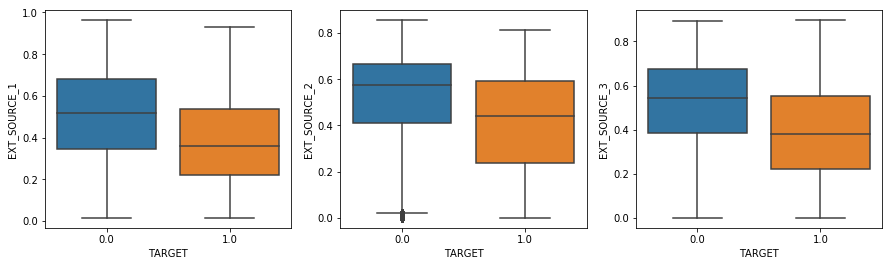

In [26]:
# 看起来label=1的三个特征都偏小
plt.figure(figsize=(15,4))
for i in range(len(feats)):
    plt.subplot(1,len(feats),i+1)
    sns.boxplot(x='TARGET', y='EXT_SOURCE_%d'%(i+1), data=full_df)

In [27]:
# 它们之间没有什么相关性
full_df[feats+['TARGET']].corr()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
EXT_SOURCE_1,1.000000,0.212987,0.181390,-0.155317
EXT_SOURCE_2,0.212987,1.000000,0.108480,-0.160472
EXT_SOURCE_3,0.181390,0.108480,1.000000,-0.178919
TARGET,-0.155317,-0.160472,-0.178919,1.000000


In [28]:
# 空值很多
full_df[feats].isnull().sum()

EXT_SOURCE_1    193910
EXT_SOURCE_2       668
EXT_SOURCE_3     69633
dtype: int64

In [29]:
full_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,0.083037,0.262949,0.139376,1.0
1,0.311267,0.622246,NaN,0.0
2,NaN,0.555912,0.729567,0.0
3,NaN,0.650442,NaN,0.0
4,NaN,0.322738,NaN,0.0
5,NaN,0.354225,0.621226,0.0
6,0.774761,0.724000,0.492060,0.0
7,NaN,0.714279,0.540654,0.0
8,0.587334,0.205747,0.751724,0.0
9,NaN,0.746644,NaN,0.0


In [30]:
# # 把是否为空值加入特征
# for c in feats:
#     full_df['isnull_' + c] = full_df[c].isnull().astype('int')
#     add_features('isnull_' + c)

### add extra data

In [31]:
def summary_extra_data(df, suffix):
    # 分类特征get_dummies
    df = pd.get_dummies(df, columns=df.columns[df.dtypes == 'object'].tolist())
    df = df.fillna(0)

    # 求平均
    df = pd.concat([
        df.groupby('SK_ID_CURR').mean(),
        df.groupby('SK_ID_CURR').size().rename('cnt'),
    ], axis=1)

    # 给特征加上前缀
    df.columns = [suffix+f for f in df.columns.tolist()]

    return df

In [32]:
# bureau = pd.read_csv('./data/input/bureau.csv')
# test_df = bureau.iloc[:100, :5]
# test_df.head()

# summary_extra_data(test_df, 'test')

**bureau.csv**

In [33]:
bureau = pd.read_csv('./data/input/bureau.csv')
bureau = bureau.drop('SK_ID_BUREAU', axis=1)

bureau = summary_extra_data(bureau, 'bureau_')

full_df = full_df.join(bureau, on='SK_ID_CURR')
add_features(bureau.columns.tolist())

**previous_application.csv**

In [34]:
prevapp = pd.read_csv('./data/input/previous_application.csv')
prevapp = prevapp.drop('SK_ID_PREV', axis=1)

prevapp = summary_extra_data(prevapp, 'prevapp_')

full_df = full_df.join(prevapp, on='SK_ID_CURR')
add_features(prevapp.columns.tolist())

**POS_CASH_balance.csv**

In [35]:
pcblc = pd.read_csv('./data/input/POS_CASH_balance.csv')
pcblc = pcblc.drop(['SK_ID_PREV', 'MONTHS_BALANCE'], axis=1)

pcblc = summary_extra_data(pcblc, 'pcblc_')

# add CNT_INSTALMENT_FUTURE devide CNT_INSTALMENT
# pcblc['pcblc_CNT_INSTALMENT_FUTURE_devide_CNT_INSTALMENT'] = pcblc['pcblc_CNT_INSTALMENT_FUTURE'] / pcblc['pcblc_CNT_INSTALMENT']

full_df = full_df.join(pcblc, on='SK_ID_CURR')
add_features(pcblc.columns.tolist())

**credit_card_balance.csv**

In [36]:
ccblc = pd.read_csv('./data/input/credit_card_balance.csv')
ccblc = ccblc.drop(['SK_ID_PREV', 'MONTHS_BALANCE'], axis=1)

ccblc = summary_extra_data(ccblc, 'ccblc_')

full_df = full_df.join(ccblc, on='SK_ID_CURR')
add_features(ccblc.columns.tolist())

**installments_payments.csv**

In [37]:
installpay = pd.read_csv('./data/input/installments_payments.csv')
installpay = installpay.drop(['SK_ID_PREV'], axis=1)

installpay = summary_extra_data(installpay, 'installpay_')

full_df = full_df.join(installpay, on='SK_ID_CURR')
add_features(installpay.columns.tolist())

In [38]:
len(feature_columns)

515

## LightGBM

In [40]:
trn_df = full_df[is_trn]
tst_df = full_df[is_tst]

X = trn_df[feature_columns]
y = trn_df[label_col]
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.20, random_state=20180521)

X_tst = tst_df[feature_columns]

d_trn = lgb.Dataset(X_trn.values, y_trn)
d_val = lgb.Dataset(X_val.values, y_val)

In [41]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 4,
    'num_leaves': 12,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.5,
    'bagging_freq': 1,
    'is_unbalance': True,
    'seed': 0,
    'reg_alpha': 0.1,
}
bst = lgb.train(params, d_trn, 500, valid_sets=[d_trn, d_val], early_stopping_rounds=20)

[1]	training's auc: 0.701727	valid_1's auc: 0.703769
Training until validation scores don't improve for 20 rounds.
[2]	training's auc: 0.708878	valid_1's auc: 0.711923
[3]	training's auc: 0.709786	valid_1's auc: 0.713289
[4]	training's auc: 0.718454	valid_1's auc: 0.720961
[5]	training's auc: 0.719495	valid_1's auc: 0.722188
[6]	training's auc: 0.721345	valid_1's auc: 0.725243
[7]	training's auc: 0.722778	valid_1's auc: 0.726973
[8]	training's auc: 0.729574	valid_1's auc: 0.733434
[9]	training's auc: 0.729144	valid_1's auc: 0.732939
[10]	training's auc: 0.730312	valid_1's auc: 0.733986
[11]	training's auc: 0.731763	valid_1's auc: 0.73538
[12]	training's auc: 0.731662	valid_1's auc: 0.735486
[13]	training's auc: 0.73263	valid_1's auc: 0.736485
[14]	training's auc: 0.733368	valid_1's auc: 0.737433
[15]	training's auc: 0.733944	valid_1's auc: 0.737942
[16]	training's auc: 0.734397	valid_1's auc: 0.738426
[17]	training's auc: 0.735421	valid_1's auc: 0.739288
[18]	training's auc: 0.735636	v

[152]	training's auc: 0.784639	valid_1's auc: 0.778005
[153]	training's auc: 0.784814	valid_1's auc: 0.778093
[154]	training's auc: 0.784946	valid_1's auc: 0.778164
[155]	training's auc: 0.78503	valid_1's auc: 0.778211
[156]	training's auc: 0.785162	valid_1's auc: 0.778275
[157]	training's auc: 0.785284	valid_1's auc: 0.778293
[158]	training's auc: 0.785384	valid_1's auc: 0.778351
[159]	training's auc: 0.785518	valid_1's auc: 0.778368
[160]	training's auc: 0.78566	valid_1's auc: 0.778364
[161]	training's auc: 0.785816	valid_1's auc: 0.778435
[162]	training's auc: 0.785951	valid_1's auc: 0.7785
[163]	training's auc: 0.786138	valid_1's auc: 0.778612
[164]	training's auc: 0.786282	valid_1's auc: 0.778677
[165]	training's auc: 0.786429	valid_1's auc: 0.778799
[166]	training's auc: 0.786618	valid_1's auc: 0.77893
[167]	training's auc: 0.78673	valid_1's auc: 0.778949
[168]	training's auc: 0.786814	valid_1's auc: 0.778998
[169]	training's auc: 0.786925	valid_1's auc: 0.779053
[170]	training's

[302]	training's auc: 0.801368	valid_1's auc: 0.78422
[303]	training's auc: 0.801433	valid_1's auc: 0.78421
[304]	training's auc: 0.801528	valid_1's auc: 0.78427
[305]	training's auc: 0.801671	valid_1's auc: 0.784337
[306]	training's auc: 0.801754	valid_1's auc: 0.784414
[307]	training's auc: 0.80183	valid_1's auc: 0.784433
[308]	training's auc: 0.801919	valid_1's auc: 0.784425
[309]	training's auc: 0.802031	valid_1's auc: 0.784451
[310]	training's auc: 0.802142	valid_1's auc: 0.784536
[311]	training's auc: 0.802229	valid_1's auc: 0.784555
[312]	training's auc: 0.802318	valid_1's auc: 0.784564
[313]	training's auc: 0.802441	valid_1's auc: 0.784649
[314]	training's auc: 0.80251	valid_1's auc: 0.784644
[315]	training's auc: 0.802561	valid_1's auc: 0.784655
[316]	training's auc: 0.802646	valid_1's auc: 0.784693
[317]	training's auc: 0.802733	valid_1's auc: 0.7847
[318]	training's auc: 0.802796	valid_1's auc: 0.784719
[319]	training's auc: 0.802834	valid_1's auc: 0.784702
[320]	training's 

[452]	training's auc: 0.813307	valid_1's auc: 0.786568
[453]	training's auc: 0.813367	valid_1's auc: 0.786585
[454]	training's auc: 0.813444	valid_1's auc: 0.786533
[455]	training's auc: 0.813509	valid_1's auc: 0.786515
[456]	training's auc: 0.813568	valid_1's auc: 0.786519
[457]	training's auc: 0.813655	valid_1's auc: 0.786505
[458]	training's auc: 0.813685	valid_1's auc: 0.786522
[459]	training's auc: 0.81372	valid_1's auc: 0.78655
[460]	training's auc: 0.813773	valid_1's auc: 0.786547
[461]	training's auc: 0.813822	valid_1's auc: 0.786546
[462]	training's auc: 0.813845	valid_1's auc: 0.786569
[463]	training's auc: 0.813951	valid_1's auc: 0.786604
[464]	training's auc: 0.813997	valid_1's auc: 0.786615
[465]	training's auc: 0.814059	valid_1's auc: 0.786597
[466]	training's auc: 0.814111	valid_1's auc: 0.786602
[467]	training's auc: 0.814193	valid_1's auc: 0.786598
[468]	training's auc: 0.814236	valid_1's auc: 0.786601
[469]	training's auc: 0.814295	valid_1's auc: 0.786555
[470]	traini

In [42]:
imp_df = pd.DataFrame([bst.feature_importance()], columns=feature_columns, index=['importance']).T.sort_values(by='importance', ascending=False)
imp_df

,importance
EXT_SOURCE_1,198
EXT_SOURCE_3,193
EXT_SOURCE_2,170
AMT_CREDIT_device_AMT_ANNUITY,147
DAYS_BIRTH,102
DAYS_EMPLOYED,97
pcblc_CNT_INSTALMENT_FUTURE,96
AMT_ANNUITY,87
AMT_CREDIT_device_AMT_GOODS_PRICE,70
installpay_AMT_PAYMENT,64


## predict

In [43]:
res_df = pd.DataFrame(bst.predict(X_tst), columns=[output_label_col])
res_df[output_id_col] = tst_df[output_id_col].values
res_df[[output_id_col, output_label_col]].to_csv(submission_path, index=False)